In [2]:
from models import networks3D
import torch
import torch.nn as nn
from torch.nn import init

In [3]:
netD = networks3D.define_D(1 + 1, 64, 'n_layers',
                                            3, 'instance', True, 'normal', 0.02, [0])

initialize network with normal


In [4]:
netD.eval()

DataParallel(
  (module): NLayerDiscriminator(
    (model): Sequential(
      (0): Conv3d(2, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (6): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
      (9): InstanceNorm3d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv3d(512, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), pad

In [6]:
input = torch.rand(1, 2, 64, 64, 64)
print(input.shape)

torch.Size([1, 2, 64, 64, 64])


In [7]:
output = netD(input)

/home/levibaljer/anaconda3/envs/unet/lib/python3.8/site-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


In [8]:
print(output.shape)

torch.Size([1, 1, 6, 6, 6])


In [ ]:
def exists(x):
    return x is not None

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv3d(dim, dim_out, (1, 3, 3), padding=(0, 1, 1))
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        return self.act(x)

In [ ]:
class WBlock(nn.Module):
    def __init__(self):
        super(WBlock, self).__init__()
        
        sequence = [nn.Upsample((32, 32, 16), mode='trilinear', align_corners=False),
                    Block(1, 32),
                    nn.Upsample((64, 64, 32), mode='trilinear', align_corners=False),
                    Block(32, 64),
                    nn.Upsample((128, 128, 64), mode='trilinear', align_corners=False),
                    Block(64, 32),
                    nn.Conv3d(32, 1, 1),
                    nn.Tanh()]

        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)

In [ ]:

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm3d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

In [ ]:
def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)
    init_weights(net, init_type, gain=init_gain)
    return net

In [ ]:
def define_W(init_type='normal', init_gain=0.02, gpu_ids=[]):
    return init_net(WBlock(), init_type, init_gain, gpu_ids)

In [ ]:
netW = define_W('normal', 0.02, [0])

In [ ]:
outW = netW(output)

In [ ]:
print(outW.shape)

In [ ]:
def convOutput(n, f, p, s):
    return ((n+(2*p)-f)/s) + 1

#### To do: set dimensions in W automatically based on patch size specifications -- first upsample = dim/(2**2), second upsample = dim/(2), third upsample = dim

In [ ]:
randImage = torch.rand(1, 1, 128, 128, 64).to('cuda:0')

In [ ]:
noisy_A = randImage * (1 + outW)

In [ ]:
print(noisy_A.shape)

## Dataloader

In [1]:
from utils.NiftiDataset import *
import utils.NiftiDataset as NiftiDataset
from torch.utils.data import DataLoader
min_pixel = int(0.1 * ((128 * 128 * 64) / 100))
trainTransforms = [
                NiftiDataset.Resample((0.45, 0.45, 0.45), False),
                NiftiDataset.Augmentation(),
                NiftiDataset.Padding((64, 64, 64))
                # NiftiDataset.RandomCrop((64, 64, 64), 0, min_pixel)
                ]
train_set = NiftiDataSet('/media/hdd/levibaljer/ExperimentingKhula', which_direction='AtoB', transforms=trainTransforms, shuffle_labels=False, train=True, outputIndices=True)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=8, pin_memory=True) 

In [2]:
print(len(train_set))

1


In [3]:
def get_data():
    for i, data in enumerate(train_loader):
        print(i)
        print(len(data))
        break
    return data

In [4]:
import matplotlib.pyplot as plt
data = get_data()

0
3


In [5]:
print(train_set.labels_list)

['/media/hdd/levibaljer/ExperimentingKhula/labels/0.nii.gz']


In [6]:
print(data[0].shape)
print(data[2])

torch.Size([1, 1, 144, 256, 256])
tensor([0])


In [15]:
myImage = data[0].to('cuda:0')

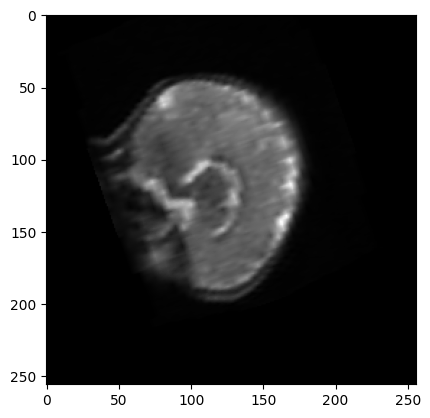

In [8]:
plt.imshow(data[0][0, 0, 64, :, :].cpu().numpy(), cmap='gray')

In [42]:
testImage = train_set.__getitem__(0)[1].unsqueeze(0).to('cuda:0')

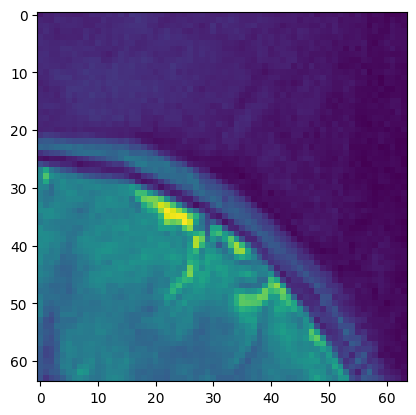

In [43]:
plt.imshow(testImage[0, 0, 32, :, :].cpu().numpy())

## DDPM

In [ ]:
from models import networks3D

In [ ]:
netG = networks3D.define_G(1, 1, 64, 'unet_256_ddm', 'instance',
                                      True, 'normal', 0.02, [0], 
                                      **{'dim': 64, 
                                         'dim_mults': (1,2,4,8), 
                                         'init_dim': 64, 
                                         'resnet_groups': 8})

In [ ]:
print(type(netG))

In [ ]:
disc_out = 0.5 + 0.001 * torch.randn((1, 1, 14, 14, 6), dtype=torch.float32)

In [ ]:
print(disc_out.shape)

In [ ]:
outW = netW(disc_out)

In [ ]:
print(outW.shape)

In [ ]:
myImage.get_device()

In [ ]:
noisy_Input = data[0] * (1 + outW)

In [ ]:
finalOut = netG(noisy_Input, outW)